# Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Solving PDE with Neural Networks: Introduction

## General Idea

Given a general, parametrized PDE of the form
$$
u_t + \mathcal{N}[u] = 0,\ x \in \Omega, \ t\in[0,T],
$$

where $u(t,x)$ denotes the latent (hidden) solution, $\mathcal{N}[\cdot]
$ is a nonlinear differential operator, and $\Omega$ is a subset of $\mathbb{R}^D$.


A neural network can be used to solve the PDE by approximating the function $u(t,x)$. For this, we define $f(x,t)$ as:
$$
f := u_t + \mathcal{N}[u],
$$
and approximate $u(t,x)$ by a neural network $u(t,x;\theta)$, where $\theta$ denotes the weights of the neural network. The neural network is trained to minimize a loss function which is the sum of MSE and the PDE residual. That is, we define the loss function as:

$$
MSE = MSE_u + MSE_f,
$$

with
$$
MSE_u = \frac{1}{N_u}\sum_{i=1}^{N_u} |u(t^i_u,x_u^i) - u^i|^2,
$$
and, 
$$
MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t_f^i,x_f^i)|^2.
$$

here, $\{t_u^i, x_u^i, u^i\}_{i=1}^{N_u}$ denote the intial and boundary condition data  on $u(t,x)$, and $\{t_f^i, x_f^i\}_{i=1}^{N_f}$ denote the collocation points where the PDE residual is evaluated. The loss $MSE_u$ corresponds to the initial and boundary data while $MSE_f$ enforces the structure imposed by the Burgers’ equation at a finite set of collocation points. This forms a physics informed neural network (PINN).

To undestant it better, let us consider the following example.

## Example

The PDE we are trying to solve is Burgers’ Equation. This is defined as:

$$
u_t + \lambda_1 u u_x - \lambda_2 u_{xx} = 0
$$

We write a speficic PDE as with the Dirichlet boundary conditions:

$$
\begin{array}{l}
u_t + u u_x - (0.01/\pi) u_{xx} = 0,\ \ \ x \in [-1,1],\ \ \ t \in [0,1],\\
u(0,x) = -\sin(\pi x),\\
u(t,-1) = u(t,1) = 0.
\end{array}
$$

This is the PDE we are trying to solve. We will use the following neural network architecture to solve this PDE.

Using the above formulation, we define:
$$
f := u_t + u u_x - (0.01/\pi) u_{xx},
$$
and then we approximate $u(t,x)$ by a neural network. For example, we can define a function like this:

```python
def u(t, x):
    u = neural_net(tf.concat([t,x],1), weights, biases)
    return u
```

Correspondingly, the physics informed neural network $f(t,x)$ takes the form:
```python
def f(t, x):
    u = u(t, x)
    u_t = tf.gradients(u, t)[0]
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    f = u_t + u*u_x - (0.01/tf.pi)*u_xx
    return f
```


>Note that this is just a pseudo-code. We will define the neural network architecture in the next section.

The loss function is defined same as above:
$$
MSE = MSE_u + MSE_f,
$$
with
$$
MSE_u = \frac{1}{N_u}\sum_{i=1}^{N_u} |u(t^i_u,x_u^i) - u^i|^2,
$$
and, 
$$
MSE_f = \frac{1}{N_f}\sum_{i=1}^{N_f}|f(t_f^i,x_f^i)|^2.
$$

Next, we'll solve a simple PDE using a neural network.

# The Static Bar Problem

## Problem Statement

The problem, which we will be solving is the static bar problem. The PDE is given as:

$$
\frac{d}{dx}\left(E(x)A(x)\frac{d}{dx}u(x)\right) +p(x) = 0
$$

The domain of x is $[0,1]$ and the boundary conditions are:

$$
u(0) = 0, \ \ \ u(1) = 0
$$

Also, we'll treat E and A as constants and set it to 1. The load is given as:
$$
p(x) = 4\pi^2\sin(2\pi x)
$$

So, the PDE we are trying to solve is:
$$
EAu_{xx} +4\pi^2\sin(2\pi x) = 0
$$

We'll define
$$
f := EAu_{xx} +4\pi^2\sin(2\pi x)
$$

We already know the analytical solution to this problem. It is given as:
$$
u(x) = \sin(2\pi x)
$$

>As the domain of the problem is $[0,1]$, the length of the rod is 1 unit. If the length changes, the solution will change accordingly. Specifically, the solution will become $\sin(\frac{2\pi x}{L})$.

## Solution

We'll start by defining some variables:

In [2]:
#E and A
E, A = 1, 1

#The function u(x) = sin(2*pi*x)
u_analytical = lambda x: torch.sin(2*torch.pi * x)

#The load function p(x) = 4*pi^2*sin(2*pi*x)
p = lambda x: 4*torch.pi**2 * torch.sin(2*torch.pi * x)

#Initial condition
u0 = torch.tensor([0., 0.], requires_grad=True, dtype=torch.float32)
x0 = torch.tensor([0., 1.], requires_grad=True, dtype=torch.float32)

In [3]:
def collocation_points(points):
    #Create a tensor of collocation points
    x = torch.linspace(0, 1, points, requires_grad=True, dtype=torch.float32) #requires_grad=True to compute the gradient
    return x

In [4]:
X_c = collocation_points(100)

Next, we'll create an `inputs` variable, which will contain the boundary points and the collcocation points. We'll use 1000 collocation points and 2 boundary points.

In [5]:
inputs = torch.cat([x0, X_c], 0) #Concatenate tensors along a given dimension
inputs = inputs.unsqueeze(1) #Add another dimension to the tensor
inputs.shape

torch.Size([102, 1])

We'll also need to change the dimensions of `x0` so that it becomes 2d.

In [6]:
x0 = x0.unsqueeze(1)

Now, we'll define the cost function. We'll create two functions:

1. The first will take `y_pred` and `y_true` as inputs and return the MSE.
2. The second will calculate the residual. It will take the `x` values and a neural network as inputs and return the residual.

In [7]:
def mseu(y_pred, y_true):
    #Mean squared error for u
    return torch.mean((y_pred - y_true)**2)

In [8]:
def msec(x, model):
    # calculates E*A*u_xx + p(x)
    u = model(x)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True,  retain_graph=True)[0]
    sum_ = E*A*u_xx + p(x)
    return torch.mean(sum_**2)

Now, we'll define a total loss function which will be the sum of the MSE and the residual.

In [9]:
def loss(inputs, model):
    #Loss function
    x0 = inputs[:2]
    x = inputs[2:]
    return mseu(model(x0), u0) + msec(x, model)

Let's define the neural network architecture. We'll use 3 hidden layers with 10, 20, 20 neurons each. We'll use the `tanh` activation function.

In [10]:
model = nn.Sequential(
    nn.Linear(1, 40),
    nn.Tanh(),
    nn.Linear(40, 40),
    nn.Tanh(),
    nn.Linear(40, 1),
)

Let's define an optimizer.

In [11]:
#create a LBFGS optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=1000, max_eval=100, tolerance_grad=1e-05, tolerance_change=1e-06)

Now, we can train the model:

In [12]:
epochs = 20
losses = []
for epoch in range(epochs):
    u = model(inputs)
    loss_ = loss(inputs, model)
    optimizer.zero_grad()
    loss_.backward()
    def closure():
        optimizer.zero_grad()
        loss_ = loss(inputs, model)
        loss_.backward()
        return loss_
    optimizer.step(closure=closure)
    losses.append(loss_.item())

    print(f"Epoch {epoch+1:>4d}/{epochs} | loss={loss_.item():.4f}")


Epoch    1/20 | loss=772.4099
Epoch    2/20 | loss=0.7346
Epoch    3/20 | loss=0.0243
Epoch    4/20 | loss=0.0071
Epoch    5/20 | loss=0.0010
Epoch    6/20 | loss=0.0002
Epoch    7/20 | loss=0.0002
Epoch    8/20 | loss=0.0002
Epoch    9/20 | loss=0.0002
Epoch   10/20 | loss=0.0002
Epoch   11/20 | loss=0.0002
Epoch   12/20 | loss=0.0002
Epoch   13/20 | loss=0.0002
Epoch   14/20 | loss=0.0002
Epoch   15/20 | loss=0.0002
Epoch   16/20 | loss=0.0002
Epoch   17/20 | loss=0.0002
Epoch   18/20 | loss=0.0002
Epoch   19/20 | loss=0.0002
Epoch   20/20 | loss=0.0002


Loss is zero! That's great. Let's plot the solution:

Let's plot the solution:

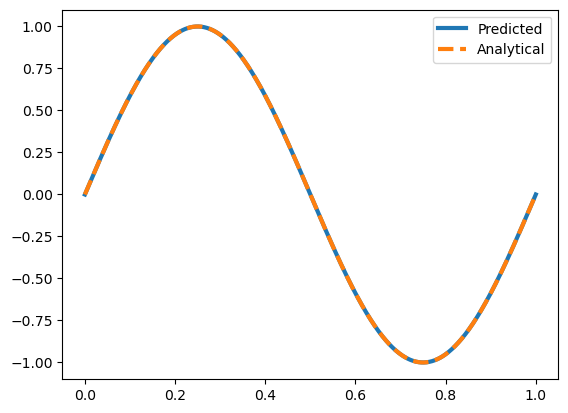

In [13]:
x_to_plot = torch.linspace(0, 1, 1000, requires_grad=True, dtype=torch.float32)
x_to_plot = x_to_plot.unsqueeze(1)
u_pred = model(x_to_plot)

plt.plot(x_to_plot.detach().numpy(), u_pred.detach().numpy(), label="Predicted", lw=3)
plt.plot(x_to_plot.detach().numpy(), u_analytical(x_to_plot).detach().numpy(), label="Analytical", linestyle="--", lw=3)
plt.legend()

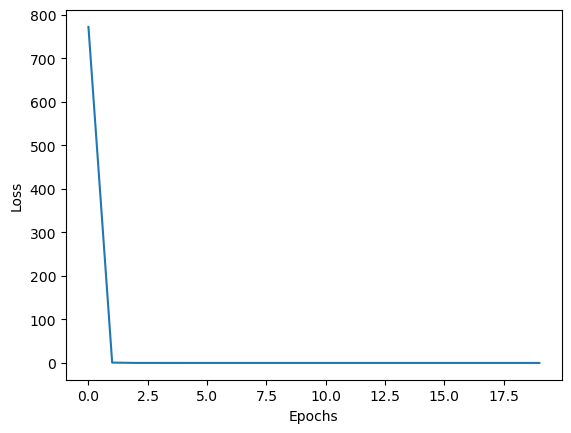

In [14]:
#plot losses
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# The Inverse Problem

## Problem Statement

Here, we'll use the PDE used above:

$$
\frac{d}{dx}\left(E(x)A(x)\frac{d}{dx}u(x)\right) +p(x) = 0
$$

to get the value of $EA(x)$ assuming that we know the solution. We'll use the same neural network architecture as above.

The differential equation becomes:
$$
E(x)u_{xx} + E_x(x)u_x + p(x) = 0
$$

now define:

$$
f:=E(x)u_{xx} + E_x(x)u_x + p(x)
$$

We already know $u$, $u_x$ and $u_{xx}$, so we will create a neural network to approximate $E(x)$.

>Please note that I've dropped the A, it is assumed to be absorbed in the E.

The analytical form of the functions are:
$$
\begin{align*}
u(x) &= \sin(2\pi x)\\
u_x(x) &= 2\pi\cos(2\pi x)\\
u_{xx}(x) &= -4\pi^2\sin(2\pi x)
\end{align*}
$$

while, we choose the following form for $E(x)$:
$$
E(x) = x^2 - x^2 +1
$$

For this, the load function becomes:

$$
p(x) = -2(3x^2 - 2x)\pi \cos(2\pi x) + 4(x^3 - x^2 + 1)\pi ^2\sin(2\pi x)
$$

## Solution

Once again, we'll start by defining some variables:

In [2]:
#The function u(x) = sin(2*pi*x)
u_analytical = lambda x: torch.sin(2*torch.pi * x)
E_analytical = lambda x: x**3 - x**2 + 1

#The load function f(x) = 4*pi^2*sin(2*pi*x)
p = lambda x: -2*(3*x**2 - 2*x)*torch.pi*torch.cos(2*torch.pi*x) + 4*(x**3 - x**2 + 1)*torch.pi**2*torch.sin(2*torch.pi*x)

In [26]:
def collocation_points(points):
    #Create a tensor of collocation points
    x = torch.linspace(0, 1, points, requires_grad=True, dtype=torch.float32) #requires_grad=True to compute the gradient
    return x

X_c = collocation_points(100)
# u_c = u_analytical(X_c)
# inputs = torch.zeros((100, 2), dtype=torch.float32)
# inputs[:, 0] = X_c
# inputs[:, 1] = u_c
inputs = X_c.unsqueeze(1)
inputs.shape

torch.Size([100, 1])

We'll define the cost function here. It will take input and the model and will return the residuals.

In [27]:
def loss(inputs, model):
    e = model(inputs)
    e_x = torch.autograd.grad(e, inputs, grad_outputs=torch.ones_like(e), create_graph=True, retain_graph=True)[0]
    
    u = u_analytical(inputs)
    u_x = torch.autograd.grad(u, inputs, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, inputs, grad_outputs=torch.ones_like(u_x), create_graph=True,  retain_graph=True)[0]

    l = torch.mean((e*u_xx + e_x*u_x + p(inputs))**2)
    return l

In [33]:
model = nn.Sequential(
    nn.Linear(1, 20),
    nn.Tanh(),
    nn.Linear(20, 1),
)

In [34]:
#create a LBFGS optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=1000, max_eval=100, tolerance_grad=1e-05, tolerance_change=1e-06)

In [35]:
epochs = 20
losses = []
for epoch in range(epochs):
    u = model(inputs)
    loss_ = loss(inputs, model)
    optimizer.zero_grad()
    loss_.backward()
    def closure():
        optimizer.zero_grad()
        loss_ = loss(inputs, model)
        loss_.backward()
        return loss_
    optimizer.step(closure=closure)
    losses.append(loss_.item())

    print(f"Epoch {epoch+1:>4d}/{epochs} | loss={loss_.item():.4f}")


Epoch    1/20 | loss=115.9809
Epoch    2/20 | loss=1.0934
Epoch    3/20 | loss=0.0106
Epoch    4/20 | loss=0.0017
Epoch    5/20 | loss=0.0001
Epoch    6/20 | loss=0.0001
Epoch    7/20 | loss=0.0001
Epoch    8/20 | loss=0.0001
Epoch    9/20 | loss=0.0001
Epoch   10/20 | loss=0.0001
Epoch   11/20 | loss=0.0001
Epoch   12/20 | loss=0.0001
Epoch   13/20 | loss=0.0001
Epoch   14/20 | loss=0.0001
Epoch   15/20 | loss=0.0001
Epoch   16/20 | loss=0.0001
Epoch   17/20 | loss=0.0001
Epoch   18/20 | loss=0.0001
Epoch   19/20 | loss=0.0001
Epoch   20/20 | loss=0.0001


Let's plot the value of $E(x)$:

In [36]:
E_true = E_analytical(X_c)
E_model = model(X_c.unsqueeze(1))

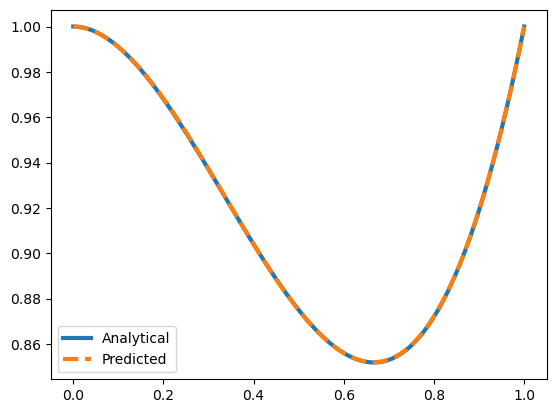

In [37]:
plt.plot(X_c.detach().numpy(), E_true.detach().numpy(), label="Analytical", lw=3)
plt.plot(X_c.detach().numpy(), E_model.detach().numpy(), label="Predicted", linestyle="--", lw=3)
plt.legend()
plt.show()

Let's plot the loss.

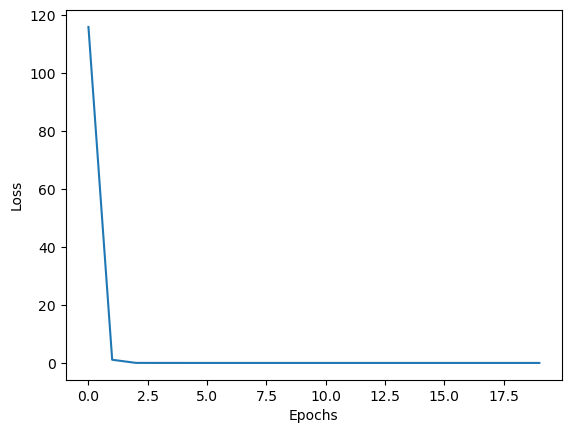

In [38]:
#plot losses
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()